## Final Project - NLP on Twitter Tweets 

In [1]:
# importing neccessary packages
import pandas as pd
import seaborn as sb
import numpy as np
import pandas as pd

# reading in twitter csv file
twitter_full = pd.read_csv('data/twitter_dataset.csv')

#  looking at first 5 observations and shape of csv
print(twitter_full.shape)
twitter_full.head()

(10000, 6)


,Tweet_ID,Username,Text,Retweets,Likes,Timestamp
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21


We can see the shape of the dataset is 10,000 columns by 6 variables. Those 6 variables are:

- `Tweet_ID` - A unique identifier that maps to a specific observation
- `Username` - The username of the person who tweeted
- `Text` - Contains the text of the tweet
- `Retweets` - Number of retweets
- `Likes` - Number of likes per tweet
- `Timestamp` - The time at which the tweet was posted

In [2]:
print(twitter_full.head())

   Tweet_ID        Username  \
0         1         julie81   
1         2   richardhester   
2         3  williamsjoseph   
3         4     danielsmary   
4         5      carlwarren   

                                                Text  Retweets  Likes  \
0  Party least receive say or single. Prevent pre...         2     25   
1  Hotel still Congress may member staff. Media d...        35     29   
2  Nice be her debate industry that year. Film wh...        51     25   
3  Laugh explain situation career occur serious. ...        37     18   
4  Involve sense former often approach government...        27     80   

             Timestamp  
0  2023-01-30 11:00:51  
1  2023-01-02 22:45:58  
2  2023-01-18 11:25:19  
3  2023-04-10 22:06:29  
4  2023-01-24 07:12:21  


Let's check for any null values in our training set 

In [3]:
# checks each column too see if null
twitter_full.isnull().sum()

Tweet_ID     0
Username     0
Text         0
Retweets     0
Likes        0
Timestamp    0
dtype: int64

There is no null so lets continue on and begain preparation for tokenization by applying the lower function to each tweets so capitlization is removed. Next we will load vadar and apply it to each row of the dataset to obtain the sentiment score of each tweet.

In [4]:
# make the tweets all in lower case to prep for tokenization
twitter_full['Text'] = twitter_full['Text'].str.lower()

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# nltk.download('vader_lexicon')

# loads in vaders pretrained sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# define function that takes inputted text and returns score of sentiment
def get_sentiment(text):
    # polarity scores using vadar will return pos, nue, neg and compound components
    scores = sentiment_analyzer.polarity_scores(text)
    return scores['compound']  

# apply function above to each row of training set
twitter_full['Sentiment Score'] = twitter_full['Text'].astype(str).apply(get_sentiment)

# checking if sentiments worked
print(twitter_full[['Text', 'Sentiment Score']].head())

                                                Text  Sentiment Score
0  party least receive say or single. prevent pre...           0.8885
1  hotel still congress may member staff. media d...           0.2960
2  nice be her debate industry that year. film wh...           0.8481
3  laugh explain situation career occur serious. ...           0.6249
4  involve sense former often approach government...           0.6705


We have now have gotten the sentiment compound scores which is considered a normalized sentiment score ranging from -1 to 1 (negative to positive). The ranges for the compound sentiment score include:

- Negative: < -0.05 
- Nuetral: between -0.5 and 0.5
- Positive: > 0.05

Let's assign these labels to each sentiment now by creating a new function `get_sentiment_label()`

In [6]:
 # defining new sentiment label function
def get_sentiment_label(score):
    if score > 0.05:
        label = 'Positive'
    elif score < -0.05:
        label = 'Negative'
    else:
        label = 'Nuetral'
    return label

twitter_full['Sentiment Label'] = twitter_full['Sentiment Score'].apply(get_sentiment_label)

twitter_full.groupby('Sentiment Label').count()

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Sentiment Score
Sentiment Label,,,,,,,
Negative,1710,1710,1710,1710,1710,1710,1710
Nuetral,389,389,389,389,389,389,389
Positive,7901,7901,7901,7901,7901,7901,7901


For the purposes of our project we do not need the full 10,000 observations. We wish to maintain a 80% / 20% split between training data and testing data. We also wish that they are split evenly between the 3 categories of `Sentiment Label` which include `Nuetral`, `Positive` and `Negative`. To proceed further we will randomize 3,600 observations from the original 10,000 to use and then test our model on the 400 (max limit for API) tweets aquired through the API.


We will instead continue with proportion stratification.

In [7]:
from sklearn.utils import resample

# proportions of orginal datsset based on sentiment 
sentiment_proportions = twitter_full['Sentiment Label'].value_counts(normalize=True)
print(f'Here is the proportions of {sentiment_proportions}') 

# training size we wish for 
train_size = 3600  

# finds the amount of observations needed for each category
sample_sizes = (sentiment_proportions * train_size).astype(int)
print(f'Here are the needed amounts of {sample_sizes}')

# stratified sampling based on proportions of orignial data 
twitter_train = twitter_full.groupby('Sentiment Label', group_keys=False).apply(
    lambda x: resample(x, n_samples=sample_sizes[x.name], random_state=100)
)

# resamples the data in order to achieve randomness
twitter_train = twitter_train.sample(frac=1, random_state=100).reset_index(drop=True)


Here is the proportions of Sentiment Label
Positive    0.7901
Negative    0.1710
Nuetral     0.0389
Name: proportion, dtype: float64
Here are the needed amounts of Sentiment Label
Positive    2844
Negative     615
Nuetral      140
Name: proportion, dtype: int32


C:\Users\Michael\AppData\Local\Temp\ipykernel_12176\2431233654.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  twitter_train = twitter_full.groupby('Sentiment Label', group_keys=False).apply(


## Exploratory Data Analysis

Posible Visualization Ideas

- Amount of tweets per category (will be proportionally stratified from original dataset) (pie chart or bar)
- Comparison to number of likes and sentiment label (maybe avergaes of both)
- We can do textblob for most common words on each sentiment rating 
- 

- Do we want to do eda on both the traininf or testing set, or purely just the traininf set

    - If we do both we can do side by sides of the same graphics if we want

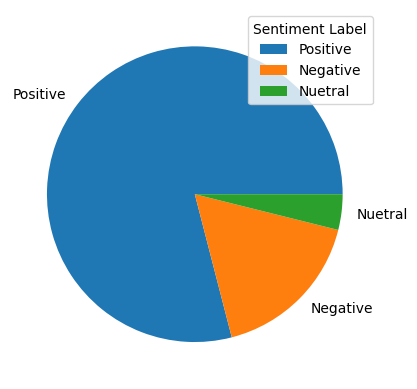

In [8]:
import matplotlib.pyplot as plt
sample_sizes

# pie chart of our distribution 
plt.pie(sample_sizes, labels = ["Positive", 'Negative', 'Nuetral']);
plt.legend(title = 'Sentiment Label', loc = 'upper right');

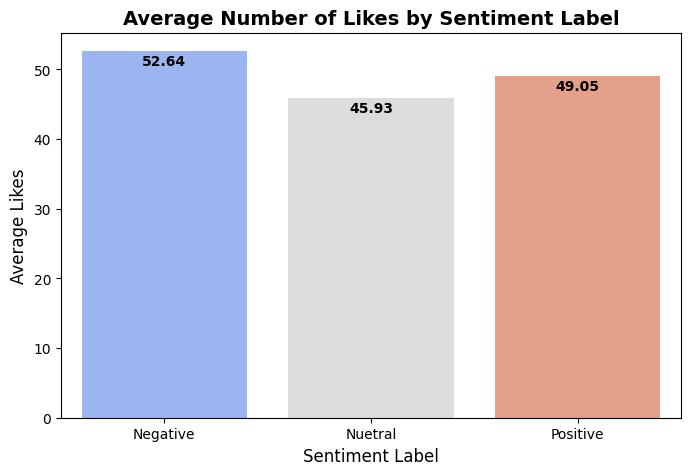

In [9]:
# calculates the average number of likes per label
average_likes = twitter_train.groupby('Sentiment Label')['Likes'].mean().reset_index()


fig, ax = plt.subplots(figsize=(8,5))

avg_like_bplot = sb.barplot(data=average_likes, x='Sentiment Label', y='Likes', hue = 'Sentiment Label',palette="coolwarm");
plt.xticks()
plt.xlabel("Sentiment Label", fontsize=12);
plt.ylabel("Average Likes", fontsize=12);
plt.title("Average Number of Likes by Sentiment Label", fontsize=14, fontweight='bold');

for rect in ax.patches:
    height = rect.get_height() # height of each bar aka mean likes
    ax.text(rect.get_x() + rect.get_width() / 2,  # x position 
            height - (height * 0.01),  # y position 
            f'{height:.2f}', 
            ha='center', va='top', fontsize=10, color='Black', fontweight='bold') 

plt.show()


In [12]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

# already handled puncuation 
# remove puncuation 
twitter_train['Text']= twitter_train['Text'].str.replace(r'[^\w\s]', '', regex=True)

# tokenize each review 
twitter_train['tokenized_text'] = twitter_train['Text'].apply(
    lambda x: word_tokenize(x) if isinstance(x, str) else [])

stop_words = set(stopwords.words('english'))

def no_stop_words(tokens):
    if isinstance(tokens, list):
        return [word for word in tokens if word not in stop_words]
    else:
        return []
    
twitter_train['clean_text'] = twitter_train['tokenized_text'].apply(no_stop_words)


twitter_train.head()

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Sentiment Score,Sentiment Label,tokenized_text,clean_text
0,8989,iedwards,same various plant environment meeting know yo...,15,35,2023-04-05 07:48:30,-0.4404,Negative,"[same, various, plant, environment, meeting, k...","[various, plant, environment, meeting, know, r..."
1,9571,murraydonald,within agency sport memory\npage no tonight pa...,14,68,2023-03-06 02:12:53,0.2500,Positive,"[within, agency, sport, memory, page, no, toni...","[within, agency, sport, memory, page, tonight,..."
2,4272,nburton,however operation some most top protect statio...,95,29,2023-01-22 12:32:14,-0.2798,Negative,"[however, operation, some, most, top, protect,...","[however, operation, top, protect, station, tr..."
3,4936,acarson,over it improve hit maintain increase expert d...,51,30,2023-02-03 13:27:33,0.6369,Positive,"[over, it, improve, hit, maintain, increase, e...","[improve, hit, maintain, increase, expert, dev..."
4,508,jeffreyhuynh,write spring into machine set trip report stor...,11,81,2023-05-08 17:47:49,0.2023,Positive,"[write, spring, into, machine, set, trip, repo...","[write, spring, machine, set, trip, report, st..."


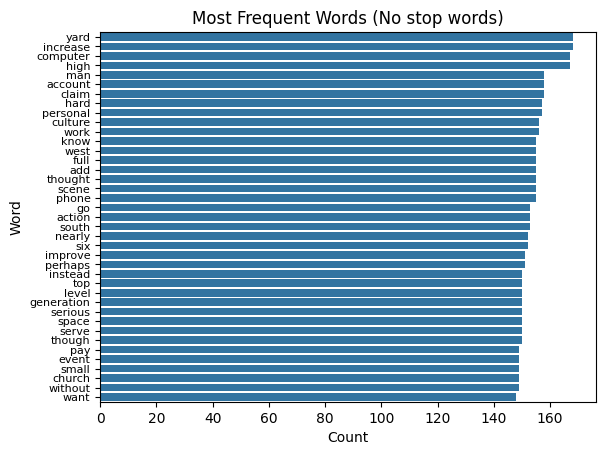

In [16]:
freq = {}

## all types of reviews
for tweet in twitter_train['clean_text']:
    if isinstance(tweet, list):
        for word in tweet:
            if word not in freq:
                freq[word] = 1
            else:
                freq[word] += 1 



sorted_review_df = pd.DataFrame(sorted(freq.items(), key=lambda item: item[1], reverse=True),
                                columns=['Word', 'Count'])

sb.barplot(sorted_review_df[1:40], x="Count", y="Word")
plt.xlabel("Count")
plt.ylabel("Word")
plt.title("Most Frequent Words (No stop words)")
plt.yticks(fontsize = 8)
plt.show()

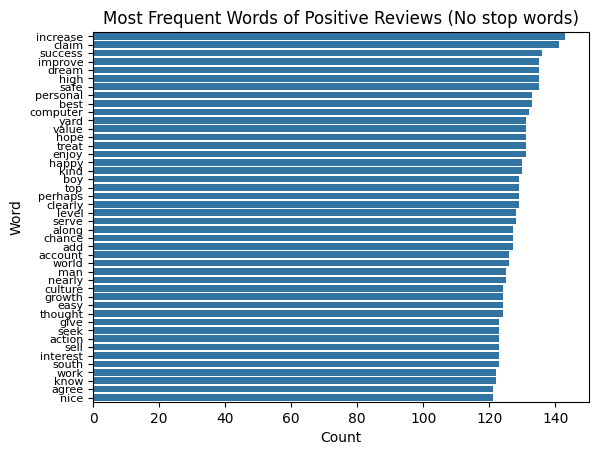

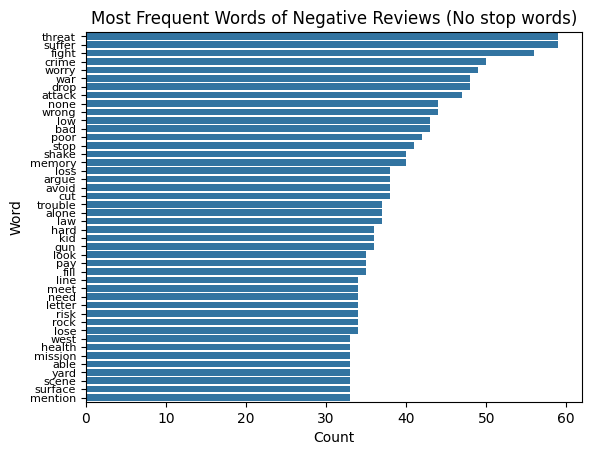

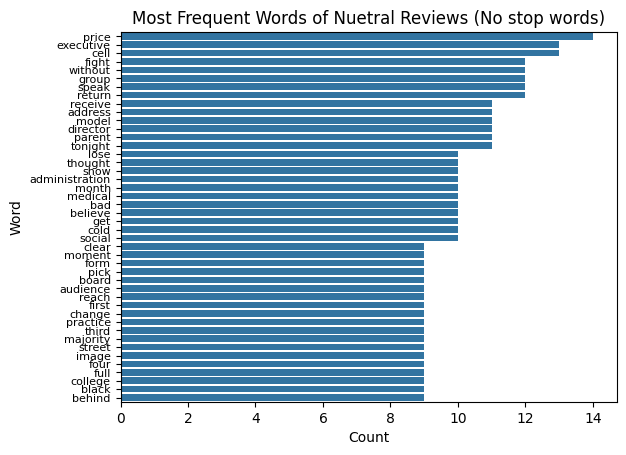

In [ ]:
# postive reviews / negative reviews
pos_freq = {}
neg_freq = {}
nue_freq = {}

for i, row in twitter_train.iterrows():
    text =  row['clean_text']
    if (row['Sentiment Label'] == 'Positive'):
        if isinstance(text, list):
            for word in text:
                if word not in pos_freq:
                    pos_freq[word] = 1
                else:
                    pos_freq[word] += 1 
    elif (row['Sentiment Label'] == 'Negative'):
        if isinstance(text, list):
            for word in text:
                if word not in neg_freq:
                    neg_freq[word] = 1
                else:
                    neg_freq[word] += 1 
    else:
        if isinstance(text, list):
            for word in text:
                if word not in nue_freq:
                    nue_freq[word] = 1
                else:
                    nue_freq[word] += 1 


# positive dataframe
post_review_df = pd.DataFrame(sorted(pos_freq.items(), key = lambda x: x[1], reverse =True), 
                              columns = ['Word', 'Count'])

sb.barplot(post_review_df[:44], x="Count", y="Word")
plt.xlabel("Count")
plt.ylabel("Word")
plt.title("Most Frequent Words of Positive Reviews (No stop words)")
plt.yticks(fontsize = 8)
plt.show()

# negative dataframe
neg_review_df = pd.DataFrame(sorted(neg_freq.items(), key=lambda x: x[1], reverse=True),
                                columns=['Word', 'Count'])
                

sb.barplot(neg_review_df[:44], x="Count", y="Word")
plt.xlabel("Count")
plt.ylabel("Word")
plt.title("Most Frequent Words of Negative Reviews (No stop words)")
plt.yticks(fontsize = 8)
plt.show()



# Neutral dataframe
neu_review_df = pd.DataFrame(sorted(nue_freq.items(), key=lambda x: x[1], reverse=True),
                                columns=['Word', 'Count'])
                

sb.barplot(neu_review_df[:44], x="Count", y="Word")
plt.xlabel("Count")
plt.ylabel("Word")
plt.title("Most Frequent Words of Nuetral Reviews (No stop words)")
plt.yticks(fontsize = 8)
plt.show()

Textblobs

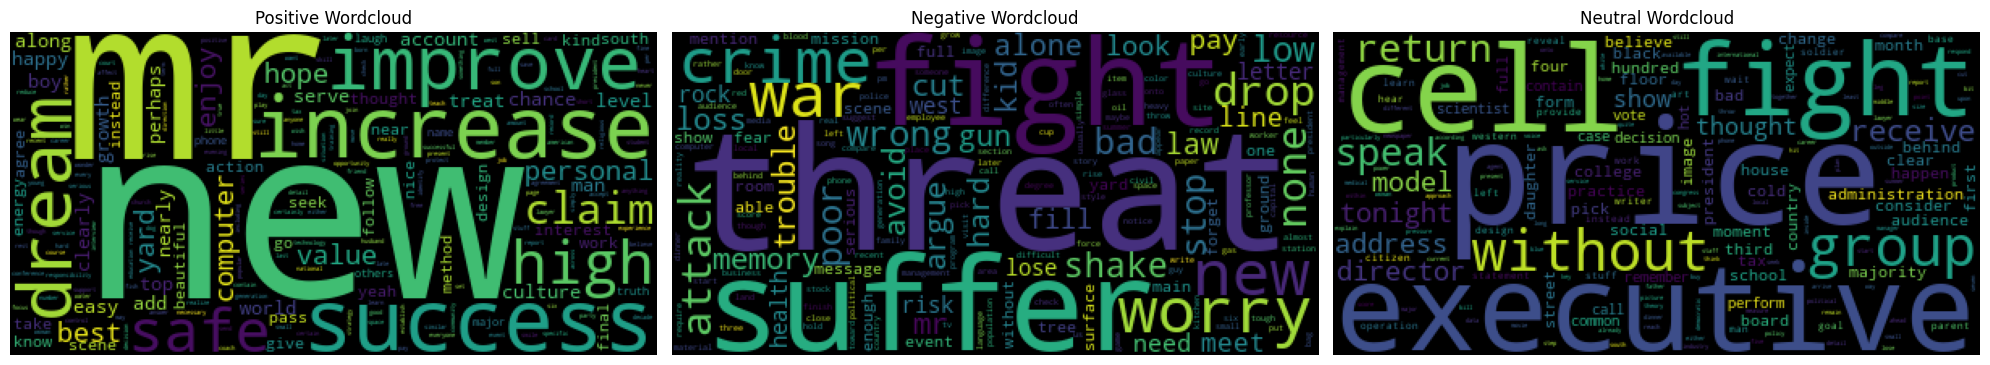

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

positive_words = []
negative_words = []
nuetral_words = []

for i , row in twitter_train.iterrows():
    if isinstance(row['clean_text'], list):  
        if row['Sentiment Label'] == 'Positive':
            positive_words.extend(row['clean_text'])
        elif row['Sentiment Label'] == 'Negative':
            negative_words.extend(row['clean_text']) 
        else:
            nuetral_words.extend(row['clean_text']) 


positive_text = ' '.join(positive_words)
negative_text = ' '.join(negative_words)
nuetral_text = ' '.join(nuetral_words)


wordcloud_pos = WordCloud().generate(positive_text)
wordcloud_neg = WordCloud().generate(negative_text)
wordcloud_nue = WordCloud().generate(nuetral_text)


# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # 1 row, 3 columns

# Assign each word cloud to a specific axis
axes[0].imshow(wordcloud_pos)
axes[0].set_title('Positive Wordcloud')
axes[0].axis("off")

axes[1].imshow(wordcloud_neg)
axes[1].set_title('Negative Wordcloud')
axes[1].axis("off")

axes[2].imshow(wordcloud_nue)
axes[2].set_title('Neutral Wordcloud')
axes[2].axis("off")

plt.tight_layout()
plt.show()


TD_IDF scores

In [27]:
twitter_train.head()

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp,Sentiment Score,Sentiment Label,tokenized_text,clean_text,clean_text_nolist
0,8989,iedwards,same various plant environment meeting know yo...,15,35,2023-04-05 07:48:30,-0.4404,Negative,"[same, various, plant, environment, meeting, k...","[various, plant, environment, meeting, know, r...",various plant environment meeting know range k...
1,9571,murraydonald,within agency sport memory\npage no tonight pa...,14,68,2023-03-06 02:12:53,0.2500,Positive,"[within, agency, sport, memory, page, no, toni...","[within, agency, sport, memory, page, tonight,...",within agency sport memory page tonight pay th...
2,4272,nburton,however operation some most top protect statio...,95,29,2023-01-22 12:32:14,-0.2798,Negative,"[however, operation, some, most, top, protect,...","[however, operation, top, protect, station, tr...",however operation top protect station treatmen...
3,4936,acarson,over it improve hit maintain increase expert d...,51,30,2023-02-03 13:27:33,0.6369,Positive,"[over, it, improve, hit, maintain, increase, e...","[improve, hit, maintain, increase, expert, dev...",improve hit maintain increase expert developme...
4,508,jeffreyhuynh,write spring into machine set trip report stor...,11,81,2023-05-08 17:47:49,0.2023,Positive,"[write, spring, into, machine, set, trip, repo...","[write, spring, machine, set, trip, report, st...",write spring machine set trip report store ide...


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# our cleaned text without stop words (list) into a string
twitter_train["clean_text_nolist"] = twitter_train["clean_text"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

# create the vector
vectorizer = TfidfVectorizer() 

tfidf_matrix = vectorizer.fit_transform(twitter_train["clean_text_nolist"])  

# change tdif to df
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# finds the mean of each word in df
tfidf_means = tfidf_df.mean().sort_values(ascending=False)

# highest and lowest 30
top_30_words = tfidf_means.head(30)
bottom_30_words = tfidf_means.tail(30)



print("Top 30 Words with Highest TF-IDF Scores:\n", top_30_words)
print("\nBottom 30 Words with Lowest TF-IDF Scores:\n", bottom_30_words)

Top 30 Words with Highest TF-IDF Scores:
 fight         0.007994
computer      0.007885
increase      0.007855
yard          0.007789
high          0.007749
account       0.007573
scene         0.007441
man           0.007432
hard          0.007407
personal      0.007406
claim         0.007399
culture       0.007343
add           0.007325
phone         0.007293
west          0.007288
work          0.007285
action        0.007278
know          0.007274
nearly        0.007254
thought       0.007236
full          0.007224
south         0.007223
church        0.007221
generation    0.007199
level         0.007172
instead       0.007147
small         0.007140
serve         0.007124
go            0.007123
almost        0.007120
dtype: float64

Bottom 30 Words with Lowest TF-IDF Scores:
 sense        0.005270
player       0.005254
bit          0.005253
ago          0.005246
cover        0.005243
difficult    0.005237
mean         0.005220
seven        0.005214
leader       0.005211
hour      

In [33]:
import itertools
from nltk.util import bigrams
from collections import Counter


# bigrams
def get_top_bigrams(text_list, n=30):
    bigram_list = []
    for review in text_list:
        if isinstance(review, list):  
            bigram_list.extend(list(bigrams(review)))
            
    bigram_counts = Counter(bigram_list).most_common(n)

    return bigram_counts     

# top 30 bigrams overall
top_bigrams = get_top_bigrams(twitter_train["clean_text"])

# df for display
bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])
print(bigram_df)





                         Bigram  Count
0          (maintain, increase)      6
1              (tonight, least)      6
2            (something, treat)      6
3              (movement, thus)      6
4              (several, party)      6
5           (head, institution)      6
6           (claim, technology)      6
7          (experience, common)      6
8                 (accept, sea)      6
9                  (miss, kind)      6
10             (practice, long)      6
11          (throughout, three)      6
12  (environmental, television)      6
13        (reflect, particular)      6
14           (member, computer)      5
15               (deep, growth)      5
16                (put, school)      5
17            (whatever, board)      5
18         (democratic, always)      5
19         (last, professional)      5
20              (single, offer)      5
21                  (late, eat)      5
22             (region, recent)      5
23             (spring, manage)      5
24              (part, su